In [1]:
import osh5io
import osh5vis
from pathlib import Path
import numpy as np
import scipy
import matplotlib.pyplot as plt
import osiris_utils as ou
import astropy
import plasmapy
plt.rcParams['font.size'] = 24

In [2]:
# This is already built in to osiris_utils but I am lazy so I will put it here.
# In the future this will be a gorgeous beautiful .py file rather than an ugly disgusting jupyter notebook, worry not.
def look_through_MS(sim_dir):
    diagnostics = []
    for item in sim_dir.rglob('*.h5'):
        parent_dir = item.parent.relative_to(sim_dir)
        if parent_dir not in diagnostics:
            diagnostics.append(parent_dir)

    if not diagnostics:
        print("No subdirectories found.")
        return

    return diagnostics

In [3]:
sim_dir = Path("/pscratch/sd/d/dschnei/perlmutter_2.7.2d/MS") # Modify as needed
diags = look_through_MS(sim_dir)
print(diags)
pha_p1_al = diags[1]
pha_p2_al = diags[4]
pha_p1_si = diags[0]
pha_p2_si = diags[3]
charge_al = diags[19]
charge_si = diags[26]

print(f"pha_p1_al: {pha_p1_al}")
print(f"pha_p2_al: {pha_p2_al}")

print(f"pha_p1_si: {pha_p1_si}")
print(f"pha_p2_si: {pha_p2_si}")
print(f"charge_al: {charge_al}")
print(f"charge_si: {charge_si}")

[PosixPath('PHA/p1x1x2/si'), PosixPath('PHA/p1x1x2/al'), PosixPath('PHA/p1x1x2/e'), PosixPath('PHA/p2x1x2/si'), PosixPath('PHA/p2x1x2/al'), PosixPath('PHA/p2x1x2/e'), PosixPath('DENSITY/e/j1'), PosixPath('DENSITY/e/j3'), PosixPath('DENSITY/e/q3'), PosixPath('DENSITY/e/q1'), PosixPath('DENSITY/e/j2'), PosixPath('DENSITY/e/q2'), PosixPath('DENSITY/e/charge'), PosixPath('DENSITY/al/j1'), PosixPath('DENSITY/al/j3'), PosixPath('DENSITY/al/q3'), PosixPath('DENSITY/al/q1'), PosixPath('DENSITY/al/j2'), PosixPath('DENSITY/al/q2'), PosixPath('DENSITY/al/charge'), PosixPath('DENSITY/si/j1'), PosixPath('DENSITY/si/j3'), PosixPath('DENSITY/si/q3'), PosixPath('DENSITY/si/q1'), PosixPath('DENSITY/si/j2'), PosixPath('DENSITY/si/q2'), PosixPath('DENSITY/si/charge'), PosixPath('FLD/b2-savg'), PosixPath('FLD/e1-savg'), PosixPath('FLD/e3-savg'), PosixPath('FLD/b1-savg'), PosixPath('FLD/e2-savg'), PosixPath('FLD/b3-savg')]
pha_p1_al: PHA/p1x1x2/al
pha_p2_al: PHA/p2x1x2/al
pha_p1_si: PHA/p1x1x2/si
pha_p2_si

In [4]:
# Osiris utils seems to be a pretty useful package for stuff like this. Let's walk through some functionality
# To begin, we can give it a specific input deck and corresponding simulation data, which can be accessed
# from the high level `osiris_utils.Simulation` object

simulation_folder = "/pscratch/sd/d/dschnei/perlmutter_2.7.2d/perlmutter_2d.2d" # Modify as needed
sim = ou.Simulation(input_deck_path=simulation_folder)
print(f"Simulation: {sim}")
print(sim.__dict__.keys())
print(f"Species are: {sim.species}")

# We can also use the InputdeckIO object to minimize back and forth and errors.
# Especially useful for our simulations where we are playing around with mass ratios
deck = ou.InputDeckIO(filename = simulation_folder)
print(deck.species)

# This appears to be the cell from hell. Takes forever to run...

ion_rqm = deck.species['al'].rqm
print(f"ion rqm: {ion_rqm}")
ion_inertial_length = np.sqrt(ion_rqm)
print(f"ion inertial length: {np.round(ion_inertial_length,2)} c/wpe")


# To calculate the Alfven velocity, we need to sample an approximate "background magnetic field" value.
# Alternatively, since it has a loose dependence on density, why don't we just calculate it in a 2D grid
# vA = B/np.sqrt(4 * np.pi * n_i * m_i)
# vA = sim['b1-savg'] / np.sqrt(4 * np.pi * (sim['al']['charge'] * deck.species['al'].rqm + sim['si']['charge']* deck.species['si'].rqm))
# Alfven_speed = sim.add_diagnostic(vA, "vA")

# Calculate the gyrofrequency
# We know B0 to be 75,000 G, but we need to normalize it to OSIRIS units.
# Calculate plasma frequency
n0 = 5e18 * astropy.units.cm**-3
wpe = plasmapy.formulary.frequencies.plasma_frequency(n0, particle="e-") / (astropy.units.rad)
print(f"wpe: {wpe}")

ion_rqm_real = 1836 * 27.0 / 6
ion_inertial_length_real = 2.28e7 * np.sqrt(ion_rqm_real / n0).value
print(f"ion inertial length (real): {np.round(ion_inertial_length_real,2)} cm")

electron_inertial_length_real = 5.31e5 * np.sqrt(1 / n0).value
print(f"electron inertial length (real): {np.round(electron_inertial_length_real,5)} cm")
# Real magnetic field value
B_real = 75000 * astropy.units.Gauss

B_norm = (astropy.constants.m_e * wpe / astropy.constants.e.si).to(astropy.units.Gauss)
print(f"B_norm: {B_norm}")

# Normalized magnetic field in OSIRIS units (dimensionless)
B_osiris = (B_real / B_norm).to(astropy.units.dimensionless_unscaled)
# B_osiris = .07
print(f"B_osiris (normalized): {B_osiris}")

# double check answer
B_real_check = B_osiris * 3.204e-3 * np.sqrt(n0)
print(f"B_real_check: {B_real_check.value}")
# Triple check answer
B_real_check =  5.681e-8 * B_osiris * wpe
print(f"B_real_check (triple check): {B_real_check.value}")
# Ion gyrofrequency: omega_ci = q_i * B / m_i = (q_i / m_i) * B
# In OSIRIS units: omega_ci / wpe = (1 / rqm) * B_osiris (where rqm = m_i/m_e)
omega_ci = B_osiris / ion_rqm
print(f"omega_ci: {omega_ci} wpe")
# Find omega_ci in physical units (Hz)
Z = 6
omega_ci_real = Z * astropy.constants.e.si * B_real / (astropy.constants.m_p * 27)
print(f"1/omega_ci (s): {(1/omega_ci_real).to(astropy.units.s)}")

Simulation: <osiris_utils.data.simulation.Simulation object at 0x7f4f656bdd30>
dict_keys(['_input_deck_path', '_input_deck', '_species', '_simulation_folder', '_diagnostics', '_species_handler'])
Species are: ['e', 'al', 'si']
{'e': Species(name=e, rqm=-1.0, q=-1.0, m=1.0), 'al': Species(name=al, rqm=145.0, q=1.0, m=145.0), 'si': Species(name=si, rqm=77.0, q=1.0, m=77.0)}
ion rqm: 145.0
ion inertial length: 12.04 c/wpe
wpe: 126146885692815.61 1 / s
ion inertial length (real): 0.93 cm
electron inertial length (real): 0.00024 cm
B_norm: 7172245.307661366 G
B_osiris (normalized): 0.010456976411540928
B_real_check: 74917.56234539673
B_real_check (triple check): 74938.92360897495
omega_ci: 7.211707870028227e-05 wpe
1/omega_ci (s): 6.263810948911892e-09 s


In [5]:
t = 35
pha_p1_times = sorted((sim_dir / pha_p1_al).glob("*.h5"))
pha_p2_times = sorted((sim_dir / pha_p2_al).glob("*.h5"))
# pha_p1_times = sorted((sim_dir / pha_p1_si).glob("*.h5"))
# pha_p2_times = sorted((sim_dir / pha_p2_si).glob("*.h5"))
density_times = sorted((sim_dir / charge_si).glob("*.h5"))
pha_p1_data = osh5io.read_h5(pha_p1_times[t].as_posix())
pha_p2_data = osh5io.read_h5(pha_p2_times[t].as_posix())
density_data = osh5io.read_h5(density_times[t*3].as_posix())

print(f"shape of phase space data p1x1x2 is: {np.shape(pha_p1_data)}")
# One of these files is 257MB and the shape is 2048 * 16 * 2048
# I want to make new phase space data that is 6000 * 16 * 512

shape of phase space data p1x1x2 is: (2048, 16, 2048)


In [6]:
def moment(data, order=0, axis=0):
    p_axis = np.asarray(data.axes[axis])
    weights = p_axis**order
    shape = [1] * data.ndim
    shape[axis] = -1
    weights = weights.reshape(shape)
    return scipy.integrate.trapezoid(data * weights, x=p_axis, axis=axis)

def n(data):
    return moment(data, order=0, axis=0)

def v(data):
    return moment(data, order=1, axis=0) / n(data)

def vth2(data):
    p_axis = np.asarray(data.axes[0])
    w = p_axis[:,None,None] - v(data)
    # print(f"shape of w: {np.shape(w)}")
    # print(f"shape of data: {np.shape(data)}")
    return scipy.integrate.trapezoid(data * np.square(w), x=p_axis, axis=0) / n(data)


n1 = n(pha_p1_data)
v1 = v(pha_p1_data)
T1 = vth2(pha_p1_data)

n2 = n(pha_p2_data)
v2 = v(pha_p2_data)
T2 = vth2(pha_p2_data)

/tmp/ipykernel_1792837/4052748052.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return scipy.integrate.trapezoid(data * weights, x=p_axis, axis=axis)
/tmp/ipykernel_1792837/4052748052.py:13: RuntimeWarning: invalid value encountered in divide
  return moment(data, order=1, axis=0) / n(data)
/tmp/ipykernel_1792837/4052748052.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return moment(data, order=1, axis=0) / n(data)
/tmp/ipykernel_1792837/4052748052.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  w = p_axis[:,None,None] - v(data)
/tmp/ipykernel_1792837/4052748052.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy

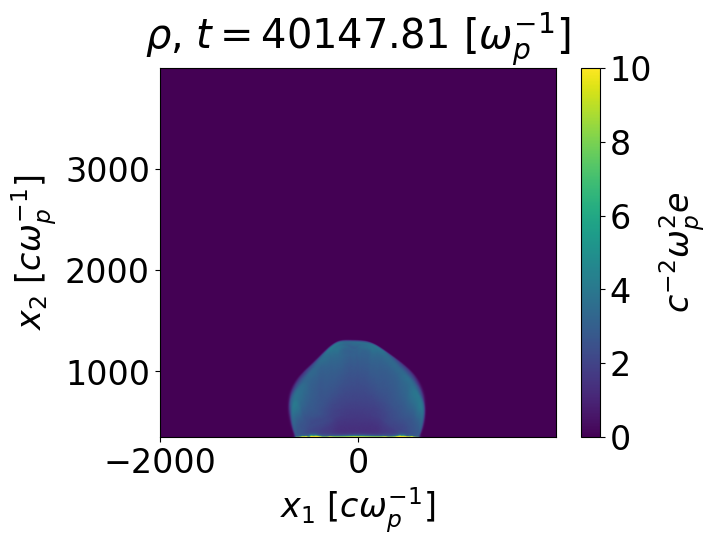

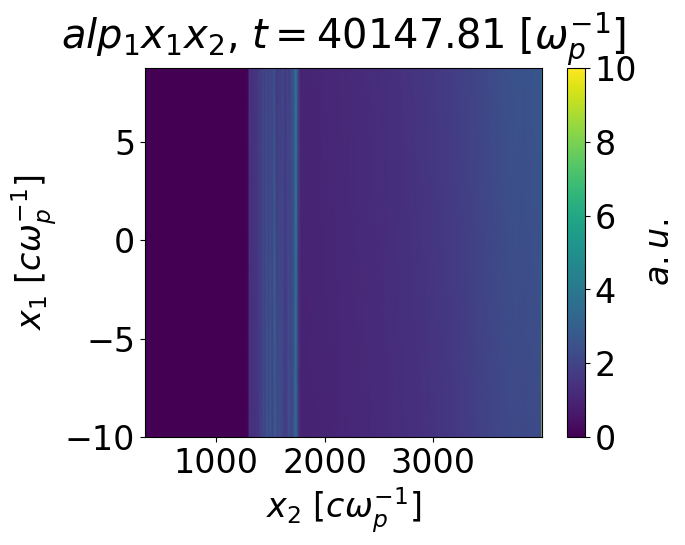

(<matplotlib.image.AxesImage at 0x7f4f362e3750>,
 <matplotlib.colorbar.Colorbar at 0x7f4f364cead0>)

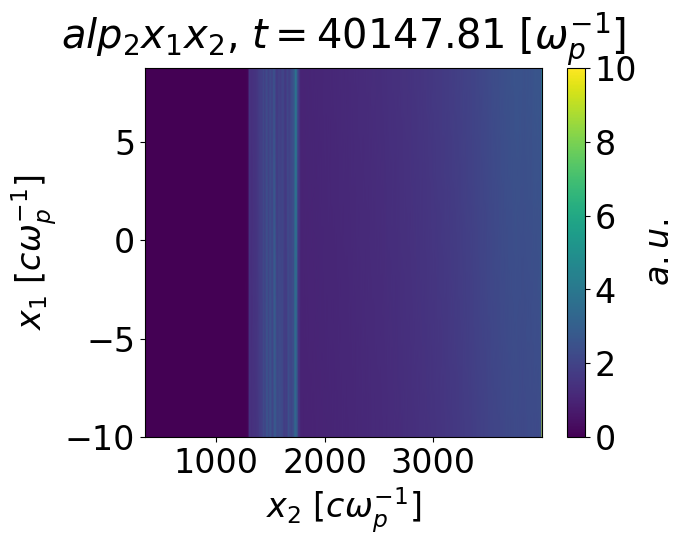

In [7]:
# Look at the data in 2D. Verify that the zeroth moments appear to match the density data.
osh5vis.osplot(density_data,vmax = 10)
plt.show()
osh5vis.osplot(n1,vmax = 10)
plt.show()
osh5vis.osplot(n2,vmax = 10)

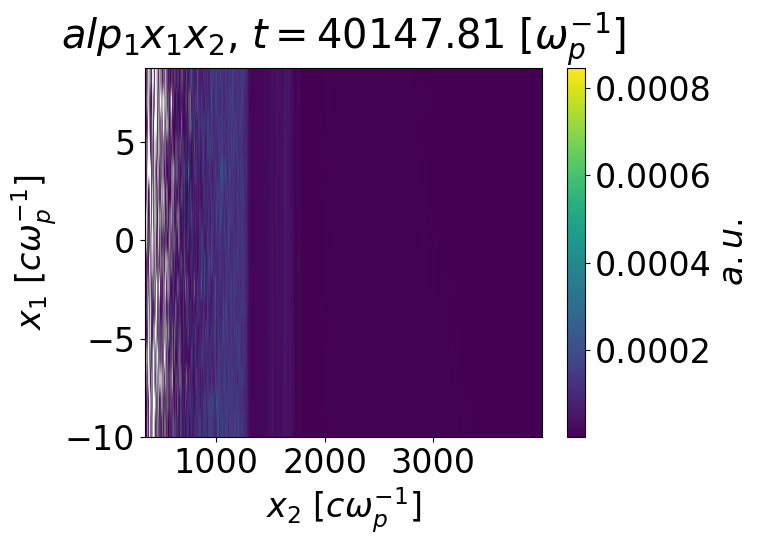

(<matplotlib.image.AxesImage at 0x7f4f36275f90>,
 <matplotlib.colorbar.Colorbar at 0x7f4f362b5590>)

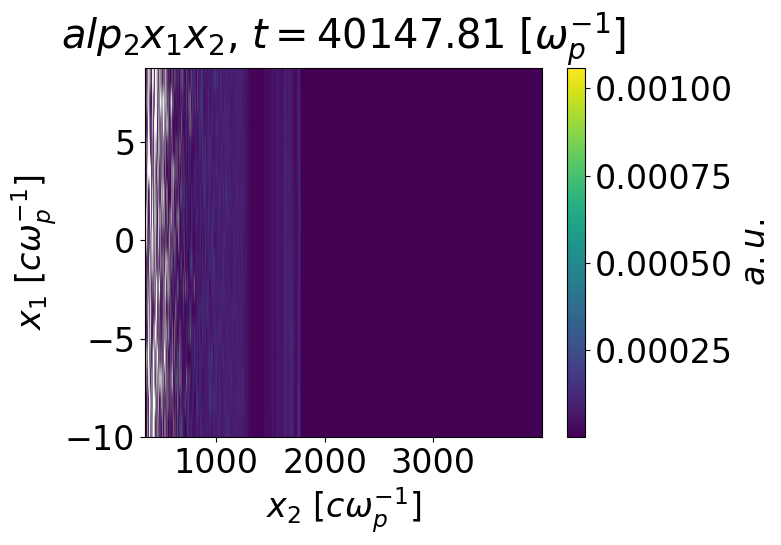

In [8]:
# Compare heating in the perpendicular and parallel directions
osh5vis.osplot(T1)
plt.show()
osh5vis.osplot(T2)

2026-02-20 08:57:41,767 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:41,769 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:41,859 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:41,861 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral


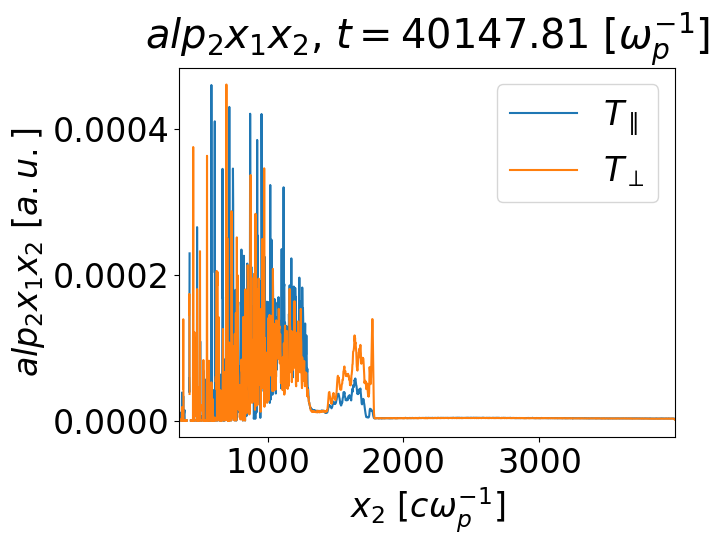

In [9]:
osh5vis.osplot(T1[np.shape(T1)[0]//2,:], label=r'$T_\parallel$')
osh5vis.osplot(T2[np.shape(T2)[0]//2,:], label=r'$T_\perp$')
plt.legend()

/tmp/ipykernel_1792837/3002974282.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  osh5vis.osplot(T2[np.shape(T2)[0]//2,:]/T1[np.shape(T1)[0]//2,:], label=r'$T_\perp/T_\parallel$')


2026-02-20 08:57:41,962 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:41,965 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:42,054 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:42,056 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral


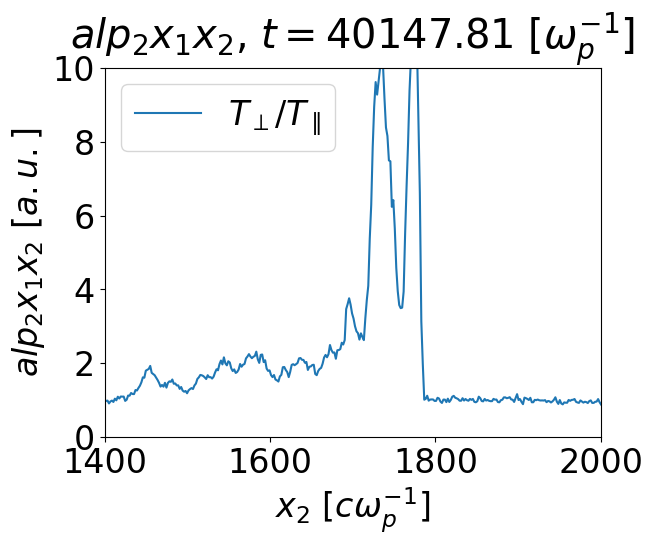

In [10]:
# It looks like we are getting significantly more heating in the parallel direction than the perpendicular direction
# Change the x limit so we aren't looking at the region with almost no particles
# osh5vis.osplot(T1[np.shape(T1)[0]//2,:], label=r'$T_\parallel$')
# osh5vis.osplot(T2[np.shape(T2)[0]//2,:], label=r'$T_\perp$')
osh5vis.osplot(T2[np.shape(T2)[0]//2,:]/T1[np.shape(T1)[0]//2,:], label=r'$T_\perp/T_\parallel$')
ax = plt.gca()
ax.set_xlim(1400, 2000)
ax.set_ylim(0, 10)
ax.legend()


/tmp/ipykernel_1792837/477621056.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  T1_real = (T1 * rqm * astropy.constants.m_e * astropy.constants.c**2).to('eV')
/tmp/ipykernel_1792837/477621056.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  T2_real = (T2 * rqm * astropy.constants.m_e * astropy.constants.c**2).to('eV')


2026-02-20 08:57:42,109 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral


2026-02-20 08:57:42,114 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:42,140 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:42,142 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:42,190 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:42,194 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:42,217 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral
2026-02-20 08:57:42,219 matplotlib.mathtext     INFO │ Substituting symbol \perp from STIXGeneral


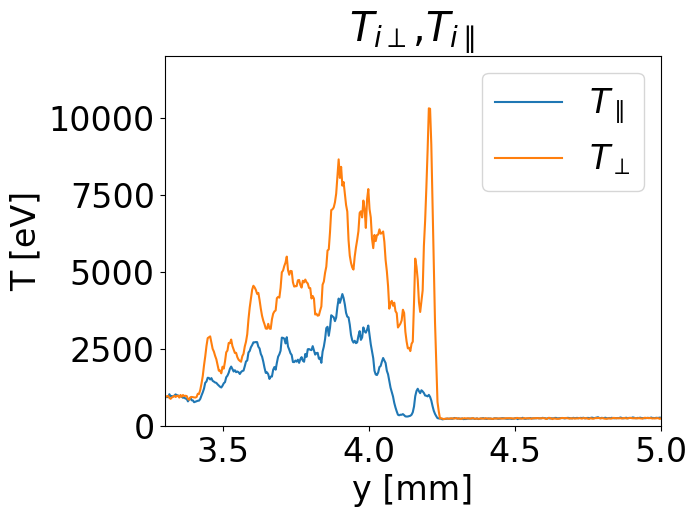

In [11]:
# It would be useful to scale these back into real units
# use vth = sqrt(T/(mc^2)) -> T = vth^2 * rqm * m_e * c^2
rqm = deck.species['al'].rqm
# print(rqm)

T1_real = (T1 * rqm * astropy.constants.m_e * astropy.constants.c**2).to('eV')
x2_axis_real = np.linspace(density_data.axes[0].min*electron_inertial_length_real*10, density_data.axes[0].max*electron_inertial_length_real*10, len(T1_real[0,:]))
plt.plot( x2_axis_real, T1_real[np.shape(T1_real)[0]//2,:], label=r'$T_\parallel$')

T2_real = (T2 * rqm * astropy.constants.m_e * astropy.constants.c**2).to('eV')
plt.plot(x2_axis_real, T2_real[np.shape(T2_real)[0]//2,:], label=r'$T_\perp$')

# plt.plot(x2_axis_real, T2_real[np.shape(T2_real)[0]//2,:]/T1_real[np.shape(T1_real)[0]//2,:], label=r'$T_\perp/T_\parallel$')
ax = plt.gca()
ax.set_xlim(3.3, 5)
ax.set_ylim(0, 12000)
plt.ylabel(r'T [eV]')
plt.xlabel('y [mm]')
# plt.title(rf"$T_\perp / T_\parallel, t = {round((density_data.run_attrs['TIME'][0] *omega_ci /omega_ci_real).to('ns'),2)}$")
plt.title(r"$T_{i\perp}$,$T_{i\parallel}$")
ax.legend()

Text(0.5, 1.0, 'Al p2x2 phase space')

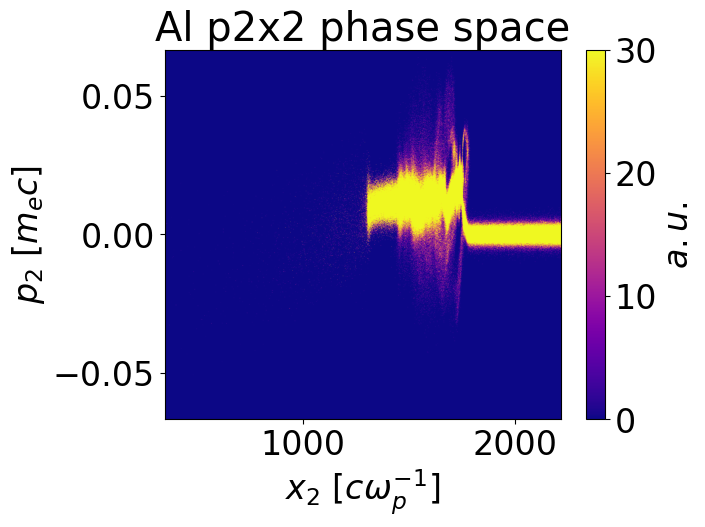

In [ ]:
osh5vis.osplot(pha_p2_data[500:-500,8,:-1000], vmax = 30,cmap = 'plasma')
# osh5vis.osplot(pha_p2_data[500:-500,8,600:-1200], vmax = 30)
plt.title("Al phase space")

In [46]:
diags[5]
# diags[3]

PosixPath('PHA/p2x1x2/e')

In [79]:
t = 35
ele_pha_p2_times = sorted((sim_dir / diags[5]).glob("*.h5"))
si_pha_p2_times = sorted((sim_dir / diags[3]).glob("*.h5"))

ele_pha_p2_data = osh5io.read_h5(ele_pha_p2_times[t].as_posix())
si_pha_p2_data = osh5io.read_h5(si_pha_p2_times[t].as_posix())

Text(0.5, 1.0, 'Si p2x2 phase space')

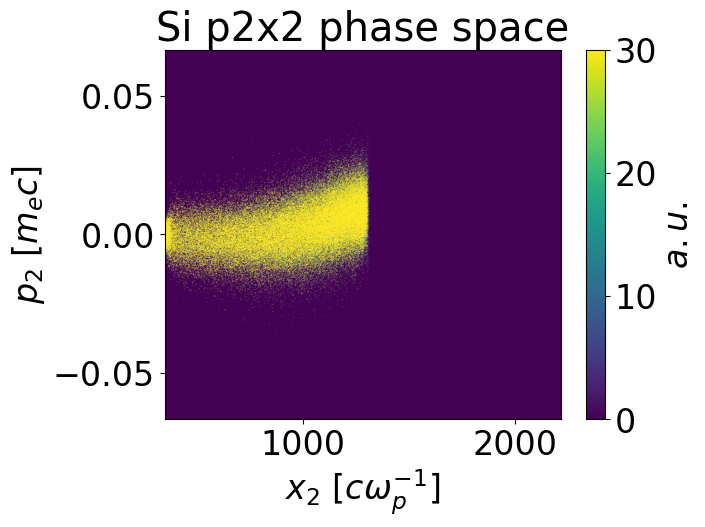

In [80]:
# osh5vis.osplot(ele_pha_p2_data[500:-500,8,600:-1200])
osh5vis.osplot(si_pha_p2_data[500:-500,8,:-1000],vmax = 30)
plt.title("Si p2x2 phase space")

/tmp/ipykernel_1722412/916179381.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  osh5vis.osplot(-1*ele_pha_p2_data[:,8,:], vmax = 30)


Text(0.5, 1.0, 'Electron p2x2 phase space')

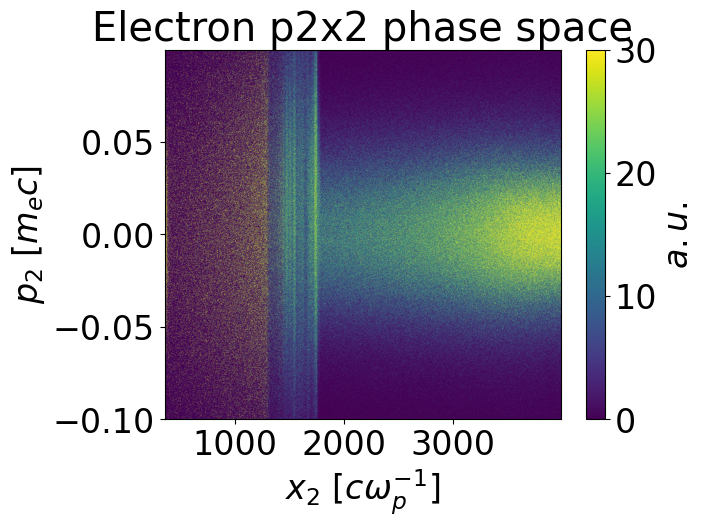

In [ ]:
osh5vis.osplot(-1*ele_pha_p2_data[500:-500,8,:-1000], vmax = 30)
plt.title("Electron p2x2 phase space")

In [83]:
def get_downstream_ion_temperatures(sim_dir, species='al', x1_slice_idx=None, 
                                     downstream_start=None, downstream_end=None,
                                     return_real_units=True, rqm=145):
    """
    Calculate mean downstream ion temperature (perpendicular and parallel) as a function of time.
    
    Parameters:
    -----------
    sim_dir : Path
        Path to MS directory containing diagnostics
    species : str
        Species name (e.g., 'al', 'si')
    x1_slice_idx : int, optional
        Index for x1 direction to take lineout (default: middle slice)
    downstream_start : float or int, optional
        Starting position/index for downstream region. If None, uses second half of domain.
    downstream_end : float or int, optional  
        Ending position/index for downstream region. If None, uses end of domain.
    return_real_units : bool
        If True, returns temperatures in eV. If False, returns in normalized units.
    rqm : float
        Mass ratio (m_ion/m_electron) for unit conversion
        
    Returns:
    --------
    times : array
        Time values for each snapshot
    T_parallel_mean : array
        Mean parallel temperature vs time
    T_perp_mean : array
        Mean perpendicular temperature vs time
    T_parallel_std : array
        Standard deviation of parallel temperature
    T_perp_std : array
        Standard deviation of perpendicular temperature
    """
    
    # Find phase space diagnostics
    diags = look_through_MS(sim_dir)
    pha_p1 = None
    pha_p2 = None
    
    for diag in diags:
        if f'PHA/p1x1x2/{species}' in str(diag):
            pha_p1 = diag
        elif f'PHA/p2x1x2/{species}' in str(diag):
            pha_p2 = diag
    
    if pha_p1 is None or pha_p2 is None:
        raise ValueError(f"Could not find phase space diagnostics for species {species}")
    
    # Get all time files
    pha_p1_files = sorted((sim_dir / pha_p1).glob("*.h5"))
    pha_p2_files = sorted((sim_dir / pha_p2).glob("*.h5"))
    
    n_times = min(len(pha_p1_files), len(pha_p2_files))
    print(f"Found {n_times} time snapshots for {species}")
    
    # Initialize arrays
    times = np.zeros(n_times)
    T_parallel_mean = np.zeros(n_times)
    T_perp_mean = np.zeros(n_times)
    T_parallel_std = np.zeros(n_times)
    T_perp_std = np.zeros(n_times)
    
    # Process each time step
    for i in range(n_times):
        # Load data
        p1_data = osh5io.read_h5(pha_p1_files[i].as_posix())
        p2_data = osh5io.read_h5(pha_p2_files[i].as_posix())
        
        # Get time
        times[i] = p1_data.run_attrs['TIME'][0]
        
        # Calculate temperatures
        T1 = vth2(p1_data)  # Parallel
        T2 = vth2(p2_data)  # Perpendicular
        
        # Determine x1 slice index (middle by default)
        if x1_slice_idx is None:
            x1_idx = T1.shape[0] // 2
        else:
            x1_idx = x1_slice_idx
        
        # Extract lineout along x2 direction
        T1_lineout = T1[x1_idx, :]
        T2_lineout = T2[x1_idx, :]
        
        # Determine downstream region
        if downstream_start is None:
            # Default: use second half of domain as downstream
            start_idx = 0 
        else:
            if isinstance(downstream_start, float):
                # Assume it's a position, find nearest index
                x2_axis = np.linspace(p1_data.axes[1].min, p1_data.axes[1].max, len(T1_lineout))
                start_idx = np.argmin(np.abs(x2_axis - downstream_start))
            else:
                start_idx = downstream_start
        
        if downstream_end is None:
            end_idx = len(T1_lineout)
        else:
            if isinstance(downstream_end, float):
                x2_axis = np.linspace(p1_data.axes[1].min, p1_data.axes[1].max, len(T1_lineout))
                end_idx = np.argmin(np.abs(x2_axis - downstream_end))
            else:
                end_idx = downstream_end
        
        # Calculate mean and std in downstream region
        downstream_mask = np.isfinite(T1_lineout[start_idx:end_idx])
        
        if np.any(downstream_mask):
            T_parallel_mean[i] = np.mean(T1_lineout[start_idx:end_idx][downstream_mask])
            T_parallel_std[i] = np.std(T1_lineout[start_idx:end_idx][downstream_mask])
            T_perp_mean[i] = np.mean(T2_lineout[start_idx:end_idx][downstream_mask])
            T_perp_std[i] = np.std(T2_lineout[start_idx:end_idx][downstream_mask])
        else:
            T_parallel_mean[i] = np.nan
            T_parallel_std[i] = np.nan
            T_perp_mean[i] = np.nan
            T_perp_std[i] = np.nan
        
        if i % 10 == 0:
            print(f"Processed {i+1}/{n_times} time steps")
    
    # Convert to real units if requested
    if return_real_units:
        conversion = (rqm * astropy.constants.m_e * astropy.constants.c**2).to('eV').value
        T_parallel_mean *= conversion
        T_parallel_std *= conversion
        T_perp_mean *= conversion
        T_perp_std *= conversion
    
    return times, T_parallel_mean, T_perp_mean, T_parallel_std, T_perp_std

In [84]:
# Example usage: Calculate downstream temperatures for aluminum ions
# You can specify the downstream region by position or index

# Option 1: Auto-detect downstream (uses second half of domain)
times, T_par, T_perp, T_par_std, T_perp_std = get_downstream_ion_temperatures(
    sim_dir, 
    species='al',
    rqm=145  # Al mass ratio
)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Convert times to physical units (nanoseconds)
times_ns = (times * omega_ci / omega_ci_real).to('ns').value

# Plot mean temperatures
ax1.plot(times_ns, T_par, label=r'$T_\parallel$', linewidth=2)
ax1.plot(times_ns, T_perp, label=r'$T_\perp$', linewidth=2)
ax1.fill_between(times_ns, T_par - T_par_std, T_par + T_par_std, alpha=0.3)
ax1.fill_between(times_ns, T_perp - T_perp_std, T_perp + T_perp_std, alpha=0.3)
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Temperature [eV]')
ax1.set_title('Mean Downstream Ion Temperature vs Time (Al)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot temperature anisotropy
T_anisotropy = T_perp / T_par
ax2.plot(times_ns, T_anisotropy, linewidth=2, color='purple')
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Isotropic')
ax2.set_xlabel('Time [ns]')
ax2.set_ylabel(r'$T_\perp / T_\parallel$')
ax2.set_title('Temperature Anisotropy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final downstream temperatures:")
print(f"  T_parallel: {T_par[-1]:.1f} ± {T_par_std[-1]:.1f} eV")
print(f"  T_perp: {T_perp[-1]:.1f} ± {T_perp_std[-1]:.1f} eV")
print(f"  Anisotropy: {T_anisotropy[-1]:.3f}")

Found 37 time snapshots for al


/tmp/ipykernel_1722412/4052748052.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return scipy.integrate.trapezoid(data * weights, x=p_axis, axis=axis)
/tmp/ipykernel_1722412/4052748052.py:13: RuntimeWarning: invalid value encountered in divide
  return moment(data, order=1, axis=0) / n(data)
/tmp/ipykernel_1722412/4052748052.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return moment(data, order=1, axis=0) / n(data)
/tmp/ipykernel_1722412/4052748052.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  w = p_axis[:,None,None] - v(data)
/tmp/ipykernel_1722412/4052748052.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy

Processed 1/37 time steps


KeyboardInterrupt: 

In [ ]:
# Advanced: Specify custom downstream region
# You can define the downstream region by spatial position or array index

# Option 2: Specify downstream region by position (in OSIRIS units: c/wpe)
# For example, if you know the shock is at x2 ~ 1500 c/wpe:
times_custom, T_par_custom, T_perp_custom, _, _ = get_downstream_ion_temperatures(
    sim_dir, 
    species='al',
    downstream_start=1500,  # Start position in c/wpe
    downstream_end=3500,    # End position in c/wpe
    rqm=145
)

# Option 3: Specify by array indices
# This is faster if you already know which indices correspond to downstream
times_idx, T_par_idx, T_perp_idx, _, _ = get_downstream_ion_temperatures(
    sim_dir, 
    species='al',
    downstream_start=1024,  # Array index
    downstream_end=-200,    # Can use negative indexing
    rqm=145
)

print("Downstream region analysis complete!")
print(f"Using custom spatial region: T_perp/T_parallel = {T_perp_custom[-1]/T_par_custom[-1]:.3f}")
print(f"Using index-based region: T_perp/T_parallel = {T_perp_idx[-1]/T_par_idx[-1]:.3f}")

In [85]:
# Helper function: Automatically find shock position from density gradient
def find_shock_position(density_data, x1_slice_idx=None, method='gradient'):
    """
    Find the shock front position from density data.
    
    Parameters:
    -----------
    density_data : osh5def.H5Data
        Density diagnostic data
    x1_slice_idx : int, optional
        Index for x1 lineout (default: middle)
    method : str
        'gradient' - uses maximum density gradient
        'threshold' - uses density threshold
        
    Returns:
    --------
    shock_position : float
        Position of shock front in OSIRIS units
    shock_index : int
        Array index of shock front
    """
    if x1_slice_idx is None:
        x1_idx = density_data.shape[0] // 2
    else:
        x1_idx = x1_slice_idx
    
    density_lineout = density_data[x1_idx, :]
    x2_axis = np.linspace(density_data.axes[1].min, 
                         density_data.axes[1].max, 
                         len(density_lineout))
    
    if method == 'gradient':
        # Find maximum density gradient (shock front)
        gradient = np.gradient(density_lineout)
        shock_idx = np.argmax(gradient)
    elif method == 'threshold':
        # Find where density exceeds 50% of max
        threshold = 0.5 * np.max(density_lineout)
        shock_idx = np.argmax(density_lineout > threshold)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    shock_position = x2_axis[shock_idx]
    
    return shock_position, shock_idx

# Example: Find shock and use it to define downstream region
density_data_example = osh5io.read_h5(sorted((sim_dir / charge_al).glob("*.h5"))[t*3].as_posix())
shock_pos, shock_idx = find_shock_position(density_data_example)

print(f"Shock position: {shock_pos:.1f} c/wpe (index: {shock_idx})")
print(f"Downstream region: from {shock_pos:.1f} to end of domain")

# Now use this to calculate downstream temperatures
times_auto, T_par_auto, T_perp_auto, _, _ = get_downstream_ion_temperatures(
    sim_dir,
    species='al',
    downstream_start=shock_idx + 100,  # Start 100 cells downstream of shock
    rqm=145
)

print(f"Automatically detected downstream T_perp/T_parallel: {T_perp_auto[-1]/T_par_auto[-1]:.3f}")

Shock position: -629.9 c/wpe (index: 856)
Downstream region: from -629.9 to end of domain
Found 37 time snapshots for al


/tmp/ipykernel_1722412/4052748052.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return scipy.integrate.trapezoid(data * weights, x=p_axis, axis=axis)
/tmp/ipykernel_1722412/4052748052.py:13: RuntimeWarning: invalid value encountered in divide
  return moment(data, order=1, axis=0) / n(data)
/tmp/ipykernel_1722412/4052748052.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return moment(data, order=1, axis=0) / n(data)
/tmp/ipykernel_1722412/4052748052.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  w = p_axis[:,None,None] - v(data)
/tmp/ipykernel_1722412/4052748052.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy

Processed 1/37 time steps


/global/homes/d/dschnei/.conda/envs/analysis/lib/python3.13/site-packages/osh5def.py:145: SyntaxWarning: invalid escape sequence '\m'
  return wavelength / (2 * np.pi), '\mu m'
/global/homes/d/dschnei/.conda/envs/analysis/lib/python3.13/site-packages/osh5def.py:154: SyntaxWarning: invalid escape sequence '\o'
  name = ('m_e', 'c', '\omega', 'e', 'n_0')
/global/homes/d/dschnei/.conda/envs/analysis/lib/python3.13/site-packages/osh5def.py:155: SyntaxWarning: invalid escape sequence '\o'
  disp_name = ['m_e', 'c', '\omega_p', 'e', 'n_0', 'a.u.']
/global/homes/d/dschnei/.conda/envs/analysis/lib/python3.13/site-packages/osh5def.py:185: SyntaxWarning: invalid escape sequence '\p'
  elif ss in ['1', '2', '\pi', '2\pi']:
/global/homes/d/dschnei/.conda/envs/analysis/lib/python3.13/site-packages/osh5def.py:185: SyntaxWarning: invalid escape sequence '\p'
  elif ss in ['1', '2', '\pi', '2\pi']:


KeyboardInterrupt: 

In [ ]:
# Compare multiple ion species
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

species_list = [
    ('al', 145, 'Aluminum'),
    ('si', 145, 'Silicon')  # Adjust rqm for Si as needed
]

for i, (species_name, rqm_val, label) in enumerate(species_list):
    try:
        times_sp, T_par_sp, T_perp_sp, _, _ = get_downstream_ion_temperatures(
            sim_dir,
            species=species_name,
            rqm=rqm_val
        )
        
        times_ns_sp = (times_sp * omega_ci / omega_ci_real).to('ns').value
        
        # Plot parallel temperature
        axes[0, 0].plot(times_ns_sp, T_par_sp, label=f'{label} $T_\\parallel$', linewidth=2)
        
        # Plot perpendicular temperature  
        axes[0, 1].plot(times_ns_sp, T_perp_sp, label=f'{label} $T_\\perp$', linewidth=2)
        
        # Plot anisotropy
        anisotropy = T_perp_sp / T_par_sp
        axes[1, 0].plot(times_ns_sp, anisotropy, label=f'{label}', linewidth=2)
        
        # Plot total temperature (assuming 2D: T_total = (T_par + 2*T_perp)/3)
        T_total = (T_par_sp + 2*T_perp_sp) / 3
        axes[1, 1].plot(times_ns_sp, T_total, label=f'{label}', linewidth=2)
        
    except Exception as e:
        print(f"Could not process {species_name}: {e}")

axes[0, 0].set_xlabel('Time [ns]')
axes[0, 0].set_ylabel('Temperature [eV]')
axes[0, 0].set_title(r'Parallel Temperature $T_\parallel$')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_xlabel('Time [ns]')
axes[0, 1].set_ylabel('Temperature [eV]')
axes[0, 1].set_title(r'Perpendicular Temperature $T_\perp$')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_xlabel('Time [ns]')
axes[1, 0].set_ylabel(r'$T_\perp / T_\parallel$')
axes[1, 0].set_title('Temperature Anisotropy')
axes[1, 0].axhline(y=1, color='k', linestyle='--', alpha=0.5)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_xlabel('Time [ns]')
axes[1, 1].set_ylabel('Temperature [eV]')
axes[1, 1].set_title(r'Total Temperature $T_{total}$')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save results to file for later analysis
output_data = {
    'times_wpe': times,  # Time in omega_pe units
    'times_ns': (times * omega_ci / omega_ci_real).to('ns').value,  # Time in ns
    'T_parallel_eV': T_par,
    'T_perpendicular_eV': T_perp,
    'T_parallel_std_eV': T_par_std,
    'T_perpendicular_std_eV': T_perp_std,
    'anisotropy': T_perp / T_par,
    'species': 'al',
    'rqm': 145,
    'simulation': str(sim_dir.parent)
}

# Save as numpy file
output_file = 'downstream_ion_temperatures_al.npz'
np.savez(output_file, **output_data)
print(f"Saved results to {output_file}")

# Load example (for future use)
# loaded_data = np.load(output_file)
# times_loaded = loaded_data['times_ns']
# T_par_loaded = loaded_data['T_parallel_eV']